<a href="https://colab.research.google.com/github/Deepty11/MSI-MSS-prediction-deep-learning/blob/main/VGG16Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.3.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np 
import itertools
import tensorflow as tf
from tensorflow import keras

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense 
from tensorflow.keras import applications 
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [3]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets
train_data_dir = '/content/drive/MyDrive/Thesis work/augmented/train'
validation_data_dir = '/content/drive/MyDrive/Thesis work/augmented/val ' 
test_data_dir = '/content/drive/MyDrive/Thesis work/augmented/test'
#test_data_dir = ‘data/test’
 
# number of epochs to train top model 
#epochs = 50 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 40 

In [4]:
#Loading vgc16 model
vgg16 = VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

58892288/58889256 [==============================] - 1s 0us/step


# Bottleneck data for train data

Creation of the weights and feature using VGG16:


In [5]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train) 
 
np.save('/content/drive/MyDrive/Thesis work/bottleneck_features_train_vgg16.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1249 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:10:38.061988


Creating a bottleneck file for the training data. (Same step for validation and testing):

In [6]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode= None, 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('/content/drive/MyDrive/Thesis work/bottleneck_features_train_vgg16.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
#train_labels = to_categorical(train_labels, num_classes=num_classes)
train_labels

Found 1249 images belonging to 2 classes.


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# Bottleneck data for validation data

In [7]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_validation_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 
 
np.save('/content/drive/MyDrive/Thesis work/bottleneck_features_validation_vgg16.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 630 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:05:36.668506


In [8]:
#validation data
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode= None, 
   shuffle=False) 
 
nb_validation_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('/content/drive/MyDrive/Thesis work/bottleneck_features_validation_vgg16.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
#validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 630 images belonging to 2 classes.


# Bottleneck data for test data

In [9]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode= None, 
    shuffle=False) 
 
nb_validation_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size)) 
 
bottleneck_features_validation = vgg16.predict_generator(generator, predict_size_validation) 
 
np.save('/content/drive/MyDrive/Thesis work/bottleneck_features_test_vgg16.npy', bottleneck_features_validation)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 623 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:05:35.812764


In [10]:
#test data

generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode= None, 
   shuffle=False) 
 
nb_test_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('/content/drive/MyDrive/Thesis work/bottleneck_features_test_vgg16.npy') 
 
# get the class labels for the training data, in the original order 
test_labels = generator_top.classes 
 
# convert the training labels to categorical vectors 
#test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 623 images belonging to 2 classes.


# Compile and Fit model

In [11]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.8)) 
# model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
# model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
   optimizer=optimizers.RMSprop(learning_rate=1e-4),
   metrics=['acc'])

history = model.fit(train_data, train_labels, 
   epochs=100,
   batch_size=64)

model.save_weights(top_model_weights_path)


end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

Epoch 1/100
20/20 [==============================] - 1s 35ms/step - loss: 0.9914 - acc: 0.5556
Epoch 2/100
20/20 [==============================] - 1s 34ms/step - loss: 0.7621 - acc: 0.5765
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6779 - acc: 0.6309
Epoch 4/100
20/20 [==============================] - 1s 35ms/step - loss: 0.7398 - acc: 0.6133
Epoch 5/100
20/20 [==============================] - 1s 34ms/step - loss: 0.7191 - acc: 0.6045
Epoch 6/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6602 - acc: 0.6325
Epoch 7/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6615 - acc: 0.6629
Epoch 8/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6253 - acc: 0.6813
Epoch 9/100
20/20 [==============================] - 1s 35ms/step - loss: 0.6321 - acc: 0.6717
Epoch 10/100
20/20 [==============================] - 1s 35ms/step - loss: 0.5620 - acc: 0.7238
Epoch 11/100
20/20 [=============================

# **Training Accuracy and Test Accuracy**

In [12]:
from sklearn.metrics import accuracy_score
train_pred = (model.predict(train_data) > 0.5).astype("int32")
#train_pred = to_categorical(train_pred, num_classes, dtype='float32')
train_acc = accuracy_score(train_labels, train_pred)

test_pred = train_pred = (model.predict(test_data) > 0.5).astype("int32")
#test_pred = to_categorical(test_pred, num_classes, dtype= 'float32')
test_acc = accuracy_score(test_labels, test_pred )

validation_pred = train_pred = (model.predict(validation_data) > 0.5).astype("int32")
#validation_pred = to_categorical(validation_pred, num_classes, dtype='float32')
validation_acc = accuracy_score(validation_labels, validation_pred)

print("Train Accuracy: " , train_acc*100, "%")
print("Test Accuracy: " , test_acc*100, "%")
print("Validation Accuracy: " , validation_acc*100, "%")

Train Accuracy:  100.0 %
Test Accuracy:  85.71428571428571 %
Validation Accuracy:  58.88888888888889 %


# **Confusion Matrix**

In [13]:

print(metrics.confusion_matrix(test_labels, test_pred))


[[216  89]
 [  0 318]]


# **Save Model**

In [14]:
# Save the Modle to file in the current working directory
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/Thesis work/VGG16model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/Thesis work/VGG16model.h5")
print("Saved model to disk")

Saved model to disk


# **Load Model**

In [15]:
# Load the Model back from file
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/Thesis work/VGG16model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Thesis work/VGG16model.h5")
print("Loaded model from disk")

Loaded model from disk


## **Evaluate model on test data**

In [ ]:
# evaluate loaded model on test data

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
prediction = loaded_model.predict_classes(test_data)
prediction = to_categorical(prediction)
accuracy_score = accuracy_score(test_labels, prediction)
print("Accuracy score: %.2f %", accuracy_score)
#score = loaded_model.evaluate(validation_data, validation_labels, verbose=0)


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score: %.2f % 0.8828250401284109


Code for visualization of the Accuracy and Loss:

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

KeyError: ignored

# **ROC AUC**

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# generate a no skill prediction (majority class)
y_score1 = model.predict_proba(test_data)
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_labels, y_score1)
print('roc_auc_score for VGG16: ', roc_auc_score(test_labels, y_score1))

roc_auc_score for VGG16:  0.9595834622125992


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


No handles with labels found to put in legend.


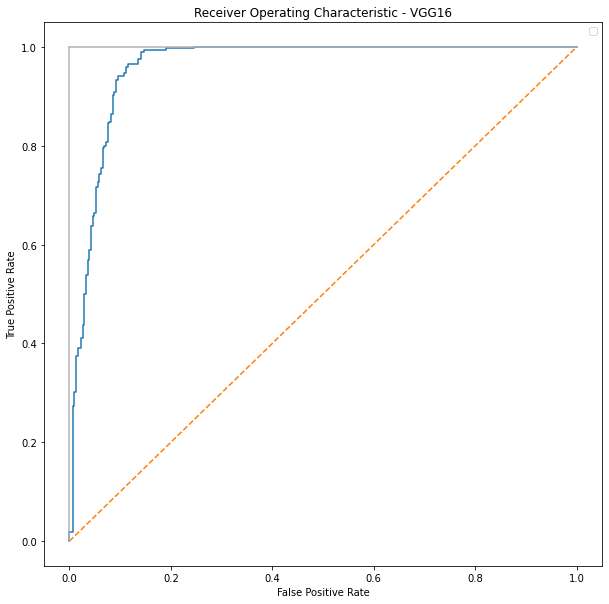

In [17]:
#Plot ROC AUC curve
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - VGG16')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()



# **Plot ROC- AUC curve**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


No Skill: ROC AUC=0.500
VGG16: ROC AUC=0.960


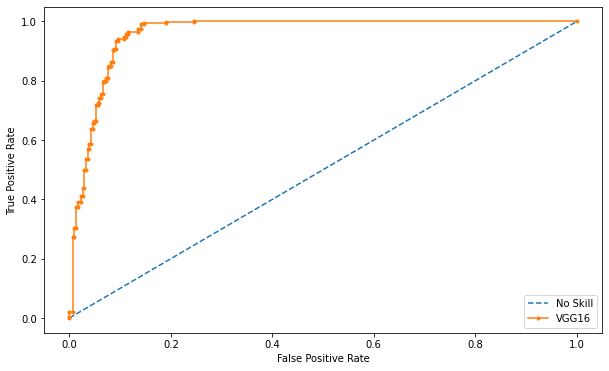

In [18]:

ns_probs = [0 for _ in range(len(test_labels))]

# predict probabilities
lr_probs = model.predict_proba(test_data)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 0]
# calculate scores
ns_auc = roc_auc_score(test_labels, ns_probs)
lr_auc = roc_auc_score(test_labels, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('VGG16: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_labels, lr_probs)
# plot the roc curve for the model
plt.subplots(1, figsize=(10,6))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='VGG16')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()